In [44]:
import cv2
import numpy as np
from scipy import ndimage
from skimage import img_as_float
from skimage import io
import matplotlib.pyplot as plt
import bm3d

In [45]:
img = img_as_float(io.imread("Denoising/original_clean.tif"))

In [46]:
# img = bm3d.bm3d(img, sigma_psd=0.5, stage_arg=bm3d.BM3DStages.ALL_STAGES)

In [47]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], np.float32)
    
    Ky = np.array([[1, 2, 1],
                   [0, 0, 0],
                   [-1, -2, -1]], np.float32)
    
    Gx = ndimage.convolve(img, Kx)
    Gy = ndimage.convolve(img, Ky)
    
    G = np.hypot(Gx, Gy)
    G = G / G.max() * 255
    theta = np.arctan2(Gy, Gx)
    
    return (G, theta)

In [48]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    # print(angle)

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                # angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                # angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                # angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

In [49]:
edge_img, theta = sobel_filters(img)

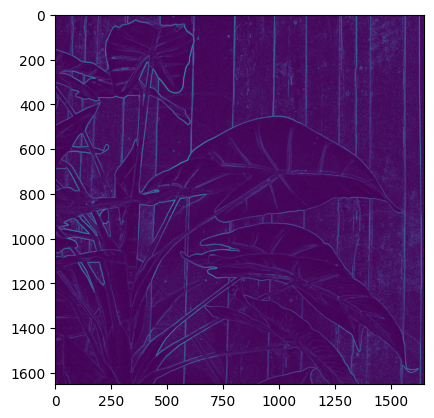

In [50]:
plt.imshow(edge_img)

In [51]:
edge_img = non_max_suppression(edge_img, theta)

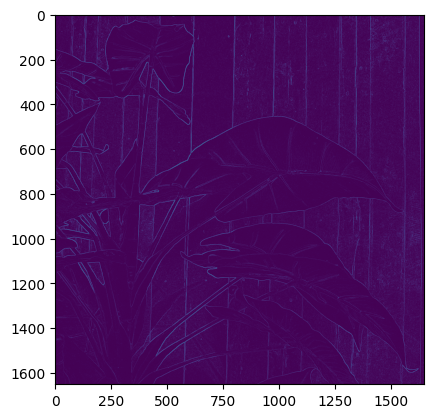

In [52]:
plt.imshow(edge_img)

In [53]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;

    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)

    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

In [54]:
edge_img, weak, strong = threshold(edge_img)

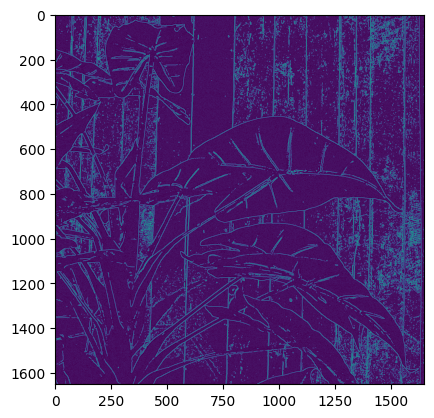

In [55]:
plt.imshow(edge_img)

In [56]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [79]:
canny_img = hysteresis(edge_img, 20)

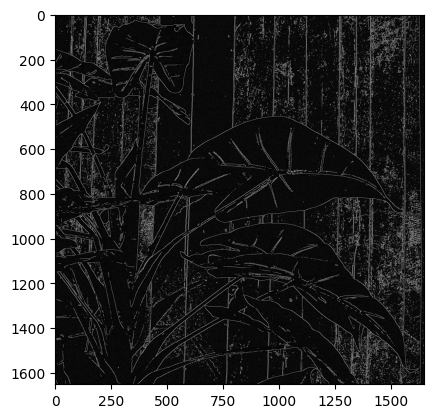

In [80]:
plt.imshow(canny_img, cmap='gray')

In [41]:
#HED USING OPENCV

In [42]:
protoPath = "hed_model/deploy.prototxt"
modelPath = "hed_model/hed_pretrained_bsds.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

In [61]:
img = cv2.imread("Denoising/original_clean.tif")
(H, W) = img.shape[:2]

In [63]:
mean_pixel_values= np.average(img, axis = (0,1))
blob = cv2.dnn.blobFromImage(img, scalefactor=0.7, size=(W, H),
                             mean=(mean_pixel_values[0], mean_pixel_values[1], mean_pixel_values[2]),
                             swapRB= False, crop=False)

In [68]:
# blob_for_plot = np.moveaxis(blob[0,:,:,:], 0,2)
# plt.imshow(blob_for_plot)

In [69]:
net.setInput(blob)
hed = net.forward()
hed = hed[0,0,:,:]  #Drop the other axes 
#hed = cv2.resize(hed[0, 0], (W, H))
hed = (255 * hed).astype("uint8")  #rescale to 0-255

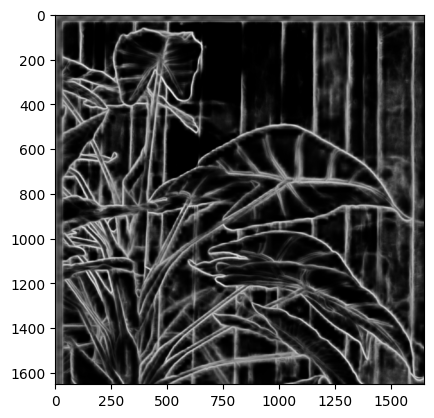

In [74]:
plt.imshow(hed, cmap='gray')

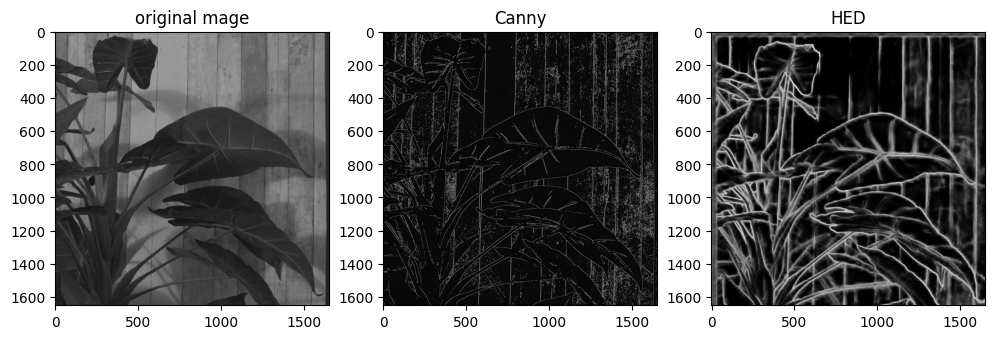

In [82]:
plt.figure(figsize=(12, 6))
plt.subplot(131)
plt.title("original mage")
plt.imshow(img)
plt.subplot(132)
plt.title("Canny")
plt.imshow(canny_img, cmap='gray')
plt.subplot(133)
plt.title("HED")
plt.imshow(hed, cmap='gray')